# Project 1 - Numerical Linear Algebra
### Kristin Fullu
Comment: I have used Github Copilot to comment some of the code, as well as help me repeat code when I can reuse what I have made with small variations. In addition, I had an issue with a Neumann corner, where I fed my entire code to ChatGPT, which helped me locate an indexing error after having struggled with it for hours. However, I have designed all of the code myself and performed all of the implementation alone.

#### Task 1

When considering this Finite Difference Method (FDM), we require that the resulting matrix A is irreducible row diagonal dominant for both the Gauss-Seidel methods to converge for all $T^{(0)}$. 

First we consider the irreducibility. If we consider the matrix as a representation for a directed graph, it is reducible only if there exist some "node", here grid point, that cannot be reached from another grid point. Because we are using central differences/the five point formula to discretize the domain, every point is actually reachable from every other point through some path. Thus, A is irreducible.

Next, we check the row diagonal dominance. We consider the formula $$\Delta T(x_i,y_j)\approx \frac{T_{i+1,j}+T_{i-1,j}+T_{i,j+1}+T_{i,j-1}-4T_{i,j}}{h^2}.$$ When creating the corresponding matrix A, all the diagonal elements will be 4, and for the inner grid points the only 4 other elements in the row will be 1, all others will be zero. On the Neumann boundaries we approximate the derivative using $$\frac{\partial T (x_i,y_j)}{\partial x} = \frac{T_{i+1,j}-T_{i-1,j}}{2h} = 0,$$ meaning $T_{i+1,j} = T_{i-1,j}$ in these cases. In these rows, we therefore have 4 on the diagonal, two elements with value one and one element with value 2. Similarly, this condition is applied twice in some corners, but the sum of the rest of the row is still at most 4. Seeing all these possible cases together, the matrix A must be row diagonal dominant.

#### Task 2

Information: I have chosen to split the domain into five main parts, as well as the boundaries. This had to be done because of how I find the point above and below the current point during computation. In hindsight, I would have preferred to implement the whole process differently, maybe by using a two dimensional grid with if-checks for boundaries or by defining a grid point as a class with neighboring points as attributes. However, I have stuck with my implementation as it was my original idea.

For the stopping criterion I have chosen to look at the 2-norm of the residual of the previous iteration. If it is small enough, the loop terminates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def GS(x0, h, tol, rep):
    '''
    Input: x0: initial value, h: step size, tol: tolerance, rep: maximum number of iterations
    Output: xReshaped: solution reshaped to plot, it: number of iterations, residualNorm: norm of residual, rReshaped: residual for plotting
    '''
    # Defining properties of the domain. Upper and lower part are denoted block. Middle part: rectangle
    blockH = int(4/h)
    blockW = int(4/h+1)
    rectH = int(6/h+1)
    rectW = int(10/h+1)

    blockN = int(blockW*blockH) # Number of grid points in a block
    rectN = int(rectW*rectH) # Number of grid points rectangle
    N = int(blockN*2+rectN) # Number of total grid points

    # Create inner grid points in their respective domain parts
    interiorGrid, interior1, interior2, interior3, interior4, interior5 = createGrid(h, blockH, blockW, rectH, rectW, blockN, rectN, "interior")

    # Create grid points for Neumann boundary conditions
    totalGrid, neuVertBottom, neuVertTop, neuLower, neuUpper = createGrid(h, blockH, blockW, rectH, rectW, blockN, rectN)

    # Create grid points for Dirichlet boundary conditions
    dirL, dirR = dirichlet(h, blockH, blockW, rectH, rectW, blockN, rectN)

    # Initialize grid with initial guess
    x = x0*np.ones(N) 

    # Set Dirichlet boundary conditions specified by project description
    x[dirL] = 20
    x[dirR] = 100

    r = np.zeros(N) # Residual vector
    rNorm = 1000 # Initialize residual norm to start while loop
    residualNorm = [] # List to store residual norm for each iteration
    
    it = 0

    while(rNorm > tol and it<rep): # While loop terminates when the residual norm is small enough or the maximum number of iterations is reached

        # Iterates over all inner points in interior1 and interior2
        for i in interior1: 
            x[i] = 0.25*(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW])
        for i in interior2:
            x[i] = 0.25*(x[i-1]+x[i+1]+x[i-blockW]+x[i+rectW])

        # Updates the vertical lower Neumann boundary points, except the lowest one as I have defined it to be pure Dirichlet
        for i in neuVertBottom[1:]:
            x[i] = 0.25*(2*x[i-1]+x[i-blockW]+x[i+blockW]) # Make exception for first and last index, since they are corners
        
        # Iterates over all inner points in interior3
        for i in interior3:
            x[i] = 0.25*(x[i-1]+x[i+1]+x[i-rectW]+x[i+rectW])

        # Updates the lower horizontal Neumann boundary points, first the corner point with special conditions, then the rest
        x[neuLower[0]] = 0.25*(x[neuLower[0]-1]+x[neuLower[0]+1]+x[neuLower[0]-blockW]+x[neuLower[0]+rectW])
        for i in neuLower[1:-1]: # Last index is a Dirichlet boundary point
            x[i] = 0.25*(2*x[i+rectW]+x[i-1]+x[i+1])

        # Iterates over all inner points in interior4
        for i in interior4:
            x[i] = 0.25*(x[i-1]+x[i+1]+x[i-rectW]+x[i+blockW])
        
        # Updates the upper horizontal Neumann boundary points, first the corner point with special conditions, then the rest
        x[neuUpper[0]] = 0.25*(x[neuUpper[0]-rectW]+x[neuUpper[0]-1]+x[neuUpper[0]+1]+x[neuUpper[0]+rectW])
        for i in neuUpper[1:-1]: # Last index is a Dirichlet boundary point
            x[i] = 0.25*(2*x[i-rectW]+x[i-1]+x[i+1])

        # Iterates over all inner points in interior5
        for i in interior5:
            x[i] = 0.25*(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW])

        # Updates the vertical upper Neumann boundary points, except the highest one as I have defined it to be pure Dirichlet
        x[neuVertTop[0]] = 0.25*(2*x[neuVertTop[0]-1]+x[neuVertTop[0]-rectW]+x[neuVertTop[0]+blockW])
        for i in neuVertTop[1:-1]:
            x[i] = 0.25*(2*x[i-1]+x[i-blockW]+x[i+blockW])

        # Residual calculation
        # Iterates in the same way as x, but using the corresponding residual formula
        for i in interior1: 
            r[i] = -(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        for i in neuVertBottom[1:]:
            r[i] = -(2*x[i-1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2) # Make exception for first and last index, since they are corners
        for i in interior2:
            r[i] = -(x[i-1]+x[i+1]+x[i-blockW]+x[i+rectW]-4*x[i])/(h**2)
        r[neuLower[0]] = -(x[neuLower[0]-1]+x[neuLower[0]+1]+x[neuLower[0]-blockW]+x[neuLower[0]+rectW]-4*x[neuLower[0]])/(h**2)
        for i in neuLower[1:-1]:
            r[i] = -(2*x[i+rectW]+x[i-1]+x[i+1]-4*x[i])/(h**2)
        for i in interior3:
            r[i] = -(x[i-1]+x[i+1]+x[i-rectW]+x[i+rectW]-4*x[i])/(h**2)
        r[neuUpper[0]] = -(x[neuUpper[0]-rectW]+x[neuUpper[0]-1]+x[neuUpper[0]+1]+x[neuUpper[0]+rectW]-4*x[neuUpper[0]])/(h**2)
        for i in neuUpper[1:-1]:
            r[i] = -(2*x[i-rectW]+x[i-1]+x[i+1]-4*x[i])/(h**2)
        for i in interior4:
            r[i] = -(x[i-1]+x[i+1]+x[i-rectW]+x[i+blockW]-4*x[i])/(h**2)
        for i in interior5:
            r[i] = -(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        r[neuVertTop[0]] = -(2*x[neuVertTop[0]-1]+x[neuVertTop[0]-rectW]+x[neuVertTop[0]+blockW]-4*x[neuVertTop[0]])/(h**2)
        for i in neuVertTop[1:-1]:
            r[i] = -(2*x[i-1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        
        # Calculate the norm of the residual in the current iteration
        rNorm = np.linalg.norm(r)
        residualNorm.append(rNorm)
        it += 1

    # Reshape the solution and residual to plot in correct shape
    rReshaped = np.zeros((blockH*2 + rectH, rectW))  # Initialize grid with correct shape
    rReshaped[:blockH, :blockW] = r[:blockN].reshape(blockH, blockW)  # First block
    rReshaped[blockH:-blockH, :] = r[blockN:blockN+rectN].reshape(rectH, rectW)  # Rectangle
    rReshaped[-blockH:, :blockW] = r[blockN+rectN:].reshape(blockH, blockW)  # Second block

    xReshaped = np.zeros((blockH*2 + rectH, rectW))  # Initialize grid with correct shape
    xReshaped[:blockH, :blockW] = x[:blockN].reshape(blockH, blockW)  # First block
    xReshaped[blockH:-blockH, :] = x[blockN:blockN+rectN].reshape(rectH, rectW)  # Rectangle
    xReshaped[-blockH:, :blockW] = x[blockN+rectN:].reshape(blockH, blockW)  # Second block

    return xReshaped, it, residualNorm, np.abs(rReshaped)

def dirichlet(h, blockH, blockW, rectH, rectW, blockN, rectN):
    '''
    Input: h: step size, dimensions of the domain
    Output: dirL: indices of Dirichlet boundary points for value 20, dirR: indices of Dirichlet boundary points for value 100
    '''

    N = int(blockN*2+rectN) # Number of grid points
    x = np.arange(0,N,1) # Grid points

    dirL = np.concatenate((x[:blockW],x[blockW:blockN+1:blockW],x[blockN+rectW:blockN+rectN:rectW],x[blockN + rectN::blockW],x[-blockW+1:])) 
    dirR = x[blockN+rectW-1:blockN+rectN-1+rectW:rectW] 
    return dirL, dirR

def createGrid(h, blockH, blockW, rectH, rectW, blockN, rectN, type = 0):
    '''
    Input: h: Step size, dimensions of the domain, type: interior or Neumann boundary
    Interior action: Initializes the grid points with corresponding index values, set all boundary points to 0 and removes them. Leaves vector of interior indices
    Neumann boundary action: Initializes the grid points with corresponding index values and slices out Neumann boundary indices
    Output: Interior points or Neumann boundary
    '''

    N = int(blockN*2+rectN) # Number of grid points
    x = np.arange(0,N,1) # Grid points

    if type == "interior":
        x[:blockW] = 0 #bottombottom
        x[blockW:blockN+1:blockW] = 0 #bottomleft
        x[blockW-1:blockN:blockW] = 0 #bottom right

        x[blockN+blockW-1:blockN+blockW+rectW-blockW] = 0 #rectbottom
        x[blockN+rectW:blockN+rectN:rectW] = 0 #rectleft
        x[blockN+rectW-1:blockN+rectN-1:rectW] = 0 #rectright
        x[blockN + rectN -rectW+blockW-1:blockN + rectN] = 0 #recttop
        
        x[blockN + rectN::blockW] = 0 #topleft
        x[blockN + rectN+ blockW-1::blockW] = 0 #topright
        x[-blockW:] = 0 #toptop

        blockStart = np.array([blockN+1, blockN+rectW+1, blockN + rectN + 1, blockN + rectN + 1 + blockW]) # The starting point of each individual array for iteration
        interior = x[x != 0] # Remove all zeros = the boundary points

        # Find the indices to split the interior array into the different interior parts
        split_index1 = np.where(interior == blockStart[0])[0][0]
        split_index2 = np.where(interior == blockStart[1])[0][0]
        split_index3 = np.where(interior == blockStart[2])[0][0]
        split_index4 = np.where(interior == blockStart[3])[0][0]

        # Split the interior array into the different interior parts
        interior1 = interior[:split_index1]
        interior2 = interior[split_index1:split_index2]
        interior3 = interior[split_index2:split_index3]
        interior4 = interior[split_index3:split_index4]
        interior5 = interior[split_index4:]

        return interior, interior1, interior2, interior3 , interior4, interior5
    
    else:
        # Slice out the Neumann boundary points
        neuVertBottom = x[blockW-1:blockN:blockW] # Neumann, vertical
        neuVertTop = x[blockN + rectN+blockW-1::blockW] # Neumann, vertical
        neuUpper = x[blockN + rectN -rectW+blockW-1:blockN + rectN]
        neuLower = x[blockN+blockW-1:blockN+blockW+rectW-blockW]
        return x, neuVertBottom, neuVertTop, neuLower, neuUpper 
    
def SOR(x0, h, w, tol, rep):
    '''
    Input: x0: initial value, h: step size, w: relaxation parameter, tol: tolerance, rep: maximum number of iterations
    Info: Code is nearly identical to GS, but with w included. See GS for more information about the code.
    Output: xReshaped: solution reshaped to plot, it: number of iterations, rReshaped: residual for plotting
    '''
    
    blockH = int(4/h)
    blockW = int(4/h+1)
    rectH = int(6/h+1)
    rectW = int(10/h+1)

    blockN = int(blockW*blockH) # Number of grid points in block
    rectN = int(rectW*rectH) # Number of grid points in rectangle
    N = int(blockN*2+rectN) # Number of grid points

    interiorGrid, interior1, interior2, interior3, interior4, interior5 = createGrid(h, blockH, blockW, rectH, rectW, blockN, rectN, "interior")
    totalGrid, neuVertBottom, neuVertTop, neuLower, neuUpper = createGrid(h, blockH, blockW, rectH, rectW, blockN, rectN)
    dirL, dirR = dirichlet(h, blockH, blockW, rectH, rectW, blockN, rectN)

    x = x0*np.ones(N) 

    x[dirL] = 20
    x[dirR] = 100

    r = np.zeros(N)
    rNorm = 1000
    residualNorm = []

    it = 0

    while(rNorm > tol and it<rep): 
        # Update
        for i in interior1: # First domain part, iterates over all inner points
            x[i] = (1-w)*x[i]+w*0.25*(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW])
        for i in neuVertBottom[1:]:
            x[i] = (1-w)*x[i]+w*0.25*(2*x[i-1]+x[i-blockW]+x[i+blockW]) # Make exception for first and last index, since they are corners
        for i in interior2:
            x[i] = (1-w)*x[i]+w*0.25*(x[i-1]+x[i+1]+x[i-blockW]+x[i+rectW])
        x[neuLower[0]] = (1-w)*x[neuLower[0]]+w*0.25*(x[neuLower[0]-1]+x[neuLower[0]+1]+x[neuLower[0]-blockW]+x[neuLower[0]+rectW])
        for i in neuLower[1:-1]:
            x[i] = (1-w)*x[i]+w*0.25*(2*x[i+rectW]+x[i-1]+x[i+1])
        for i in interior3:
            x[i] = (1-w)*x[i]+w*0.25*(x[i-1]+x[i+1]+x[i-rectW]+x[i+rectW])
        for i in interior4:
            x[i] = (1-w)*x[i]+w*0.25*(x[i-1]+x[i+1]+x[i-rectW]+x[i+blockW])
        x[neuUpper[0]] = (1-w)*x[neuUpper[0]]+w*0.25*(x[neuUpper[0]-rectW]+x[neuUpper[0]-1]+x[neuUpper[0]+1]+x[neuUpper[0]+rectW])
        for i in neuUpper[1:-1]:
            x[i] = (1-w)*x[i]+w*0.25*(2*x[i-rectW]+x[i-1]+x[i+1])
        for i in interior5:
            x[i] = (1-w)*x[i]+w*0.25*(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW]) 
        x[neuVertTop[0]] = (1-w)*x[neuVertTop[0]]+w*0.25*(2*x[neuVertTop[0]-1]+x[neuVertTop[0]-rectW]+x[neuVertTop[0]+blockW])
        for i in neuVertTop[1:-1]:
            x[i] = (1-w)*x[i]+w*0.25*(2*x[i-1]+x[i-blockW]+x[i+blockW]) 

        # Residual calculation
        for i in interior1: # First domain part, iterates over all inner points
            r[i] = -(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        for i in neuVertBottom[1:]:
            r[i] = -(2*x[i-1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        for i in interior2:
            r[i] = -(x[i-1]+x[i+1]+x[i-blockW]+x[i+rectW]-4*x[i])/(h**2)
        r[neuLower[0]] = -(x[neuLower[0]-1]+x[neuLower[0]+1]+x[neuLower[0]-blockW]+x[neuLower[0]+rectW]-4*x[neuLower[0]])/(h**2)
        for i in neuLower[1:-1]:
            r[i] = -(2*x[i+rectW]+x[i-1]+x[i+1]-4*x[i])/(h**2)
        for i in interior3:
            r[i] = -(x[i-1]+x[i+1]+x[i-rectW]+x[i+rectW]-4*x[i])/(h**2)
        r[neuUpper[0]] = -(x[neuUpper[0]-rectW]+x[neuUpper[0]-1]+x[neuUpper[0]+1]+x[neuUpper[0]+rectW]-4*x[neuUpper[0]])/(h**2)
        for i in neuUpper[1:-1]:
            r[i] = -(2*x[i-rectW]+x[i-1]+x[i+1]-4*x[i])/(h**2)
        for i in interior4:
            r[i] = -(x[i-1]+x[i+1]+x[i-rectW]+x[i+blockW]-4*x[i])/(h**2)
        for i in interior5:
            r[i] = -(x[i-1]+x[i+1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        r[neuVertTop[0]] = -(2*x[neuVertTop[0]-1]+x[neuVertTop[0]-rectW]+x[neuVertTop[0]+blockW]-4*x[neuVertTop[0]])/(h**2)
        for i in neuVertTop[1:-1]:
            r[i] = -(2*x[i-1]+x[i-blockW]+x[i+blockW]-4*x[i])/(h**2)
        
        rNorm = np.linalg.norm(r)
        residualNorm.append(rNorm)
        it += 1

    rReshaped = np.zeros((blockH*2 + rectH, rectW))  # Initialize grid with correct shape
    rReshaped[:blockH, :blockW] = r[:blockN].reshape(blockH, blockW)  # First block
    rReshaped[blockH:-blockH, :] = r[blockN:blockN+rectN].reshape(rectH, rectW)  # Rectangle
    rReshaped[-blockH:, :blockW] = r[blockN+rectN:].reshape(blockH, blockW)  # Second block

    xReshaped = np.zeros((blockH*2 + rectH, rectW))  # Initialize grid with correct shape
    xReshaped[:blockH, :blockW] = x[:blockN].reshape(blockH, blockW)  # First block
    xReshaped[blockH:-blockH, :] = x[blockN:blockN+rectN].reshape(rectH, rectW)  # Rectangle
    xReshaped[-blockH:, :blockW] = x[blockN+rectN:].reshape(blockH, blockW)  # Second block
    
    return xReshaped, it, residualNorm, np.abs(rReshaped)


#### Task 3

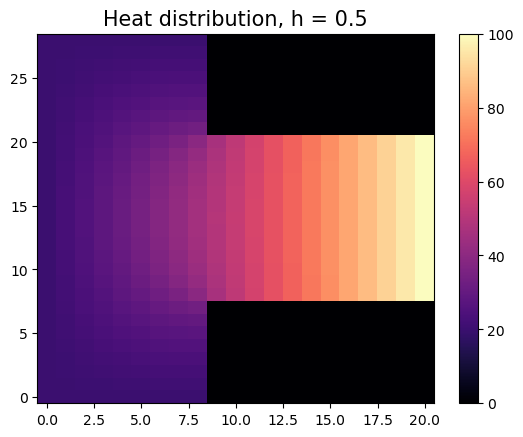

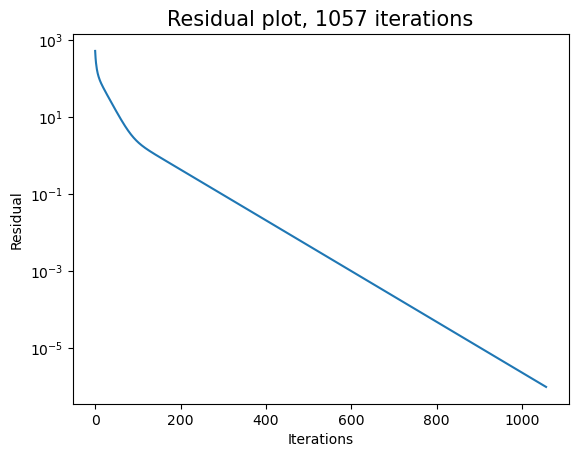

In [2]:
# h = 0.5

# Compute the solution using Gauss-Seidel and an initial guess of 50
x, it, residual, r = GS(50,0.5,1e-6,1500)

# Plot the solution and residual
plt.imshow(x, cmap = 'magma', aspect='auto', origin='lower')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Heat distribution, h = 0.5', fontsize=15)
plt.show()

plt.semilogy(np.arange(0,it,1), residual)
plt.title(f'Residual plot, {it} iterations', fontsize=15)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.show()

# Code for plotting the final residual
# plt.imshow(r, cmap = 'magma', aspect='auto', origin='lower')
# plt.colorbar()  # Add a colorbar to show the scale
# plt.title('Heat distribution, h = 0.5', fontsize=15)
# plt.show()

Comment: When plotting the residual of the last iteration before termination, I notice a accumulation of error along the lower horizontal Neumann boundary. At first I believed this to be caused by an indexing error, but I have double checked my code and find nothing I believe to be causing this. I therefore believe that the error must be caused by the Neumann boundary meeting the Dirichlet boundary in the lower "rectangle" corner, as the error seems to "bleed" from here along with the iterations. I have however deemed the error as negligible as it is of order $10^{-7}$, which is quite small in the big picture, and chose to proceed with the tasks. I also believe my iteration direction might be a part of the cause, but I am not really sure what happens.

#### Task 4

As we know that the discretization error is $O(h^2)$, there is no point in having a stopping criteria smaller than $h^2=0.25^2=0.0625$, as any smaller values will be affected by the discretization error. I therefore choose the tolerance in my code to be $10^{-2}$.

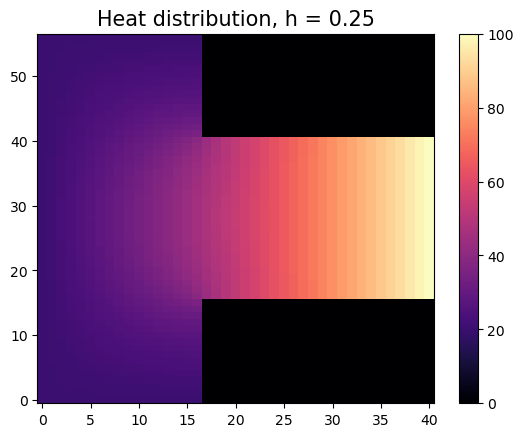

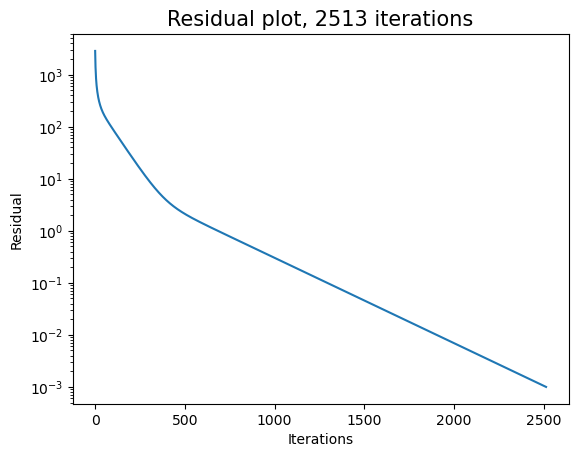

In [3]:
# h = 0.25

# Compute the solution using Gauss-Seidel
x, it, residual, r = GS(50,0.25,1e-3,3000)

# Plot the solution and residual
plt.imshow(x, cmap = 'magma', aspect='auto', origin='lower')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Heat distribution, h = 0.25', fontsize=15)
plt.show()

plt.semilogy(np.arange(0,it,1), residual)
plt.title(f'Residual plot, {it} iterations', fontsize=15)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.show()

#### Task 5

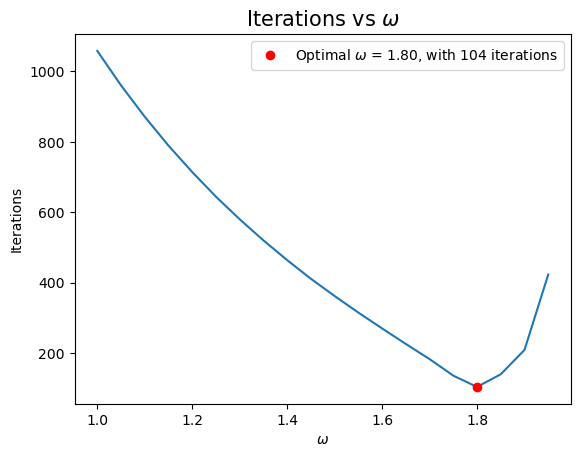

In [4]:
w = np.arange(1,2,0.05) # Omega must be between 1 and 2
iterations = []

for om in w:
    # Compute the solution using SOR, with different values of omega
    x, it, residual, r = SOR(50,0.5,om,1e-6,1500)
    iterations.append(it)

minimum = min(iterations)
corrW = w[iterations.index(minimum)]

plt.plot(w, iterations)
plt.plot(corrW, minimum, 'ro', label = f'Optimal $\omega$ = {corrW:.2f}, with {minimum} iterations')
plt.title('Iterations vs $\omega$', fontsize=15)
plt.xlabel('$\omega$')
plt.ylabel('Iterations')
plt.legend()
plt.show()

From the previous plot, we see a significant decrease with relatively small changes of $\omega$. We can now study the neighborhood around the minimum value to see how the decrease relates to even smaller changes.

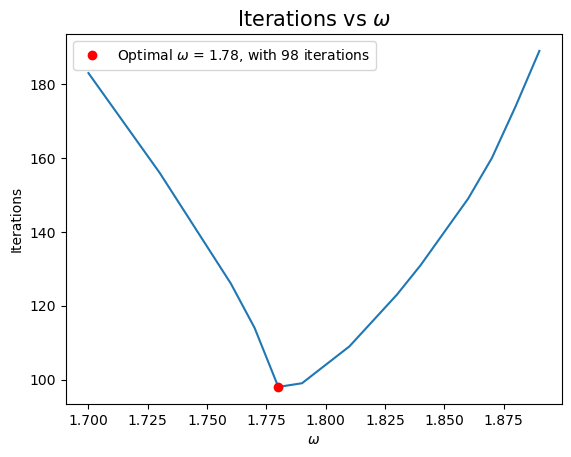

In [5]:
w = np.arange(1.7,1.9,0.01) # Omega must be between 1 and 2
iterations = []

for om in w:
    # Compute the solution using SOR, with different values of omega
    x, it, residual, r = SOR(50,0.5,om,1e-6,1500)
    iterations.append(it)

minimum = min(iterations)
corrW = w[iterations.index(minimum)]

plt.plot(w, iterations)
plt.plot(corrW, minimum, 'ro', label = f'Optimal $\omega$ = {corrW:.2f}, with {minimum} iterations')
plt.title('Iterations vs $\omega$', fontsize=15)
plt.xlabel('$\omega$')
plt.ylabel('Iterations')
plt.legend()
plt.show()

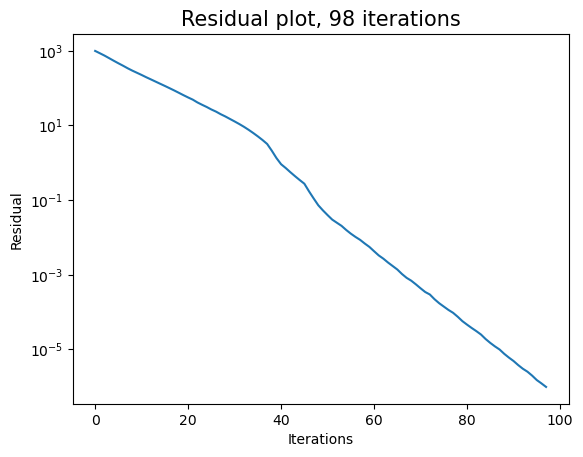

In [2]:
x, it, residual, r = SOR(50,0.5,1.78,1e-6,1500)

plt.semilogy(np.arange(0,it,1), residual)
plt.title(f'Residual plot, {it} iterations', fontsize=15)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.show()

From this, we can better see how sensitive the method really is to the change. The reduction from $\omega = 1.75$ to $\omega = 1.78$ results in about 40 less iterations. After the minima is hit, the increase is sudden.

#### Task 6
We now look at the modified Neumann boundary conditions that are $$\frac{\partial T}{\partial n}+\gamma T = 0.$$

If we for example apply this to the vertical Neumann boundaries and discretize as before, we get the expression $$T_{i+1,j}=T_{i-1,j}-2h\gamma T_{i,j} = 0 $$ for the corresponding fictious right node we use to compute the value at the boundary. Applying this to the five point formula, we get the equation $$\Delta T(x_i,y_j)\approx \frac{T_{i-1,j}-2h\gamma T_{i,j}+T_{i-1,j}+T_{i,j+1}+T_{i,j-1}-4T_{i,j}}{h^2} = 0$$ at this boundary. Rearranging, we get $$ 4T_{i,j} + 2h\gamma T_{i,j} = 2T_{i-1,j}+T_{i,j+1}+T_{i,j-1}.$$ Considering the corresponding row of matrix A at this point, we get the equation $$|4+2h\gamma| \geq 4 \Rightarrow (4+2h\gamma)^2 \geq 4^2 $$ 

$$\Rightarrow 16h\gamma + 4h^2\gamma^2 \geq 0 \Rightarrow \gamma(\gamma+4/h)\geq 0,$$ 
which holds either if $\gamma \geq 0$ or $\gamma \leq -\frac{4}{h}$.

Similar computations can be done for the horizontal Neumann boundaries. It is worth to note that the derivatives in this and previous task are taken as directional derivatives, meaning the direction affects the discretization. Throughout the project I have defined the normal to point out of the domain. This means that for the derivative at the lower horizontal Neumann boundary we must solve the equation $$T_{i,j-1}=T_{i,j+1}-2h\gamma T_{i,j} = 0$$ for $T_{i,j-1}$, resulting in the same result as before. Because of the central differences used throughout the project, the irreducibility of A is only affected by the value of $\gamma$ if it makes updates not possible. This means that A is reducible only in the case that $2h\gamma = -4 \Rightarrow \gamma = -\frac{2}{h}$. This value does not lie in our allowed domain for $\gamma$ needed for diagonal dominance, and thus making sure diagonal dominance holds, we also ensure irreducibility.